In [1]:
import sys
from pathlib import Path

sys.path.append(r"/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from linearmodels.panel import PanelOLS
from io import StringIO
import matplotlib.lines as mlines
from sklearn.preprocessing import StandardScaler
import time
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from data_analysis.data_fetcher.data_fetcher_class import DataFetcher
from data_collection.consts import  DB_PARAMS

In [2]:
fetcher = DataFetcher(
    db_params=DB_PARAMS,
    reports_table="reports_2",
    targets_table="targets_yf",
)

Available regressors:
 - avg_default_verbolizer
 - avg_shrink_verbolizer
 - doc_len
 - eps_surprise
 - f_size
 - full_list_default_verbolizer
 - full_list_shrink_verbolizer
 - hv_orig_score
 - lm_orig_score
 - max_abs_default
 - max_abs_shrink
 - max_default_verbolizer
 - max_shrink_verbolizer
 - md_hv1
 - md_hv2
 - md_hv3
 - md_lm1
 - md_lm2
 - md_lm3
 - min_default_verbolizer
 - min_shrink_verbolizer
 - stretch_default
 - stretch_shrink
Available sectors:
 - Technology (92)
 - Industrials (86)
 - Financial Services (85)
 - Healthcare (66)
 - Consumer Cyclical (58)
 - Consumer Defensive (40)
 - Real Estate (32)
 - Utilities (32)
 - Energy (30)
 - Basic Materials (23)
 - Communication Services (22)


/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:111: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:92: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [3]:
df_q = fetcher.fetch_data(
    regressors=[
        'stretch_default',
        'eps_surprise',
        'f_size',
        'doc_len'
        ],
    report_filters={'report_type' : ['10-Q']},
       prepare_fixed_effects=True,
    )

/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:130: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Expanding list regressor 'stretch_default' into 107 columns...


/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:161: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:169: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  companies_df = pd.read_sql_query(query, conn)


In [4]:
df_q.isna().sum()

report_type          0
eps_surprise         0
f_size               0
doc_len              0
segment_1            0
                  ... 
four_day_r_vol     127
five_day_r_vol     127
six_day_r_vol      127
seven_day_r_vol    127
full_q_r_vol       127
Length: 139, dtype: int64

In [5]:
class FEModeler:
    def __init__(self, df: pd.DataFrame,):
        self.original_df = df.copy()
        self.df = df.copy()
        self.var_names = df.columns
        self.params_dict = {}

    @staticmethod
    def extract_params(summary, regressor_name: str) -> pd.Series:
        coef_table = summary.tables[1].as_html()
        coef_table_io = StringIO(coef_table)
        df = pd.read_html(coef_table_io, header=0, index_col=0)[0]
        df.columns = ['Parameter', 'std_err', 'T-stat', 'P-value', 'Lower CI', 'Upper CI']
        return df.loc[regressor_name, ['Parameter', 'std_err', 'P-value', 'Lower CI', 'Upper CI']].copy()

    def fit(self, data: pd.DataFrame, formula: str):
        model = PanelOLS.from_formula(formula, data=data, check_rank=False)
        result = model.fit(cov_type='kernel')
        return result.summary
    
    @staticmethod
    def try_convert_numeric(col):
        try:
            return pd.to_numeric(col)
        except Exception:
            return col

    def compute_adaptive_lasso(self, additional_regs: list[str] = None):
        """
        Run adaptive Lasso for each (target, timeframe) and store non-zero coefficients.
        
        Args:
            additional_regs: List of additional regressor names to include (e.g., ['f_size', 'eps_surprise'])
        """
        self.lasso_coefs = {}
    
        targets = ['returns', 'e_returns', 'abn_returns', "r_vol"]
        time_frames = ['2_day', '3_day', '4_day', '5_day', '6_day', '7_day', 'full_quarter']
        var_names = self.df.columns
        base_regs = var_names[4:111]
        all_additional = additional_regs if additional_regs else []
    
        for target in targets:
            self.lasso_coefs[target] = {}
    
            for frame in time_frames:
                y_col = 111 + targets.index(target) * 7 + time_frames.index(frame)
                y_name = var_names[y_col]
    
                cols = list(base_regs) + all_additional + [y_name]
                data = self.df[cols].dropna().apply(self.try_convert_numeric)
    
                X = data[list(base_regs) + all_additional].values
                y = data[y_name].values
    
                # Adaptive weights based on OLS (ridge-stabilized in case of multicollinearity)
                ols_coef = np.linalg.pinv(X) @ y
                weights = 1 / (np.abs(ols_coef) + 1e-6)

                alpha_ridge = 1.0  # or any small positive value
                ridge_coef = np.linalg.inv(X.T @ X + alpha_ridge * np.eye(X.shape[1])) @ X.T @ y
                weights = 1 / (np.abs(ridge_coef) + 1e-6)
    
                X_weighted = X / weights
    
                model = LassoCV(cv=5, max_iter=10000).fit(X_weighted, y)
                print(model.coef_)
                coefs_raw = model.coef_ / weights  
    
                names = list(base_regs) + all_additional
                coefs_dict = {
                    name: coef for name, coef in zip(names, coefs_raw)
                    if abs(coef) > 1e-6
                }
    
                self.lasso_coefs[target][frame] = coefs_dict
        return self.lasso_coefs

    def plot_adaptive_lasso(self, save=False):
        """
        Plot bar charts of adaptive Lasso coefficients (including zero) for each (target, timeframe) combination.

        Parameters:
        -----------
        save : bool, optional
            If True, saves the plots in a subdirectory named "ALasso_plots" (default is False).
        """
        base_regs = list(self.df.columns[4:111])  # Adjust this range if needed

        # Create directory if saving is enabled
        if save:
            os.makedirs("ALasso_plots", exist_ok=True)

        for target, frame_dict in self.lasso_coefs.items():
            for frame, coef_dict in frame_dict.items():
                coefs = {reg: coef_dict.get(reg, 0.0) for reg in base_regs}  # Fill missing with 0

                names = list(coefs.keys())
                values = list(coefs.values())
                x = np.arange(len(names))

                plt.figure(figsize=(14, 5))
                plt.bar(x, values, color='tab:purple', width=0.6)
                plt.axhline(0, color='black', linewidth=1)
                plt.xticks(x, names, rotation=90, fontsize=7)
                plt.title(f'Adaptive Lasso Coefficients — {target}, {frame}')
                plt.xlabel('Regressor')
                plt.ylabel('Coefficient')
                plt.tight_layout()

                if save:
                    # Create a filename-safe version of the title
                    filename = f"ALasso_{target}_{frame}.png".replace(" ", "_").replace("/", "-")
                    plt.savefig(os.path.join("ALasso_plots", filename), dpi=300, bbox_inches='tight')
                    plt.show()
                    plt.close()
                else:
                    plt.show()



In [6]:
list(df_q.isna().sum())

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 9,
 0,
 0,
 0,
 0,
 0,
 0,
 9,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 127,
 127,
 127,
 127,
 127,
 127,
 127]

In [7]:
df_q

report_type  eps_surprise        f_size  doc_len  \
company date                                                      
A       2019.1        10-Q        0.0402  2.447506e+10   206555   
        2019.2        10-Q        0.1007  2.068122e+10   225121   
        2019.3        10-Q        0.0681  2.119690e+10   226010   
        2020.1        10-Q        0.1379  2.463511e+10   198101   
        2020.2        10-Q        0.0732  2.647768e+10   234441   
...                    ...           ...           ...      ...   
ZTS     2021.2        10-Q        0.1034  9.173499e+10   184510   
        2022.1        10-Q        0.2500  8.318959e+10   147594   
        2022.2        10-Q        0.1316  8.346320e+10   169968   
        2022.3        10-Q        0.1233  6.164240e+10   176716   
        2023.1        10-Q        0.1081  7.688532e+10   138322   

                           segment_1             segment_2  \
company date                                                 
A       2019.1  -0.03204994834959507  -0.03204994834959507   
        2019.2   0.12897019274532795   0.12897019274532795   
        2019.3   0.12485391274094582   0.12485391274094582   
        2020.1     0.147981820628047     0.147981820628047   
        2020.2  -0.10681508667767048  -0.10681508667767048   
...                              ...                   ...   
ZTS     2021.2   0.21606134623289108   0.21606134623289108   
        2022.1    0.2463041953742504    0.2463041953742504   
        2022.2     0.128679309040308     0.128679309040308   
        2022.3   0.13532592356204987   0.13532592356204987   
        2023.1   0.21359403431415558   0.21359403431415558   

                           segment_3             segment_4  \
company date                                                 
A       2019.1  -0.03204994834959507  -0.03204994834959507   
        2019.2   0.12897019274532795   0.12897019274532795   
        2019.3   0.12485391274094582   0.12485391274094582   
        2020.1     0.147981820628047     0.147981820628047   
        2020.2  -0.10681508667767048  -0.10681508667767048   
...                              ...                   ...   
ZTS     2021.2   0.21606134623289108   0.21606134623289108   
        2022.1    0.2463041953742504    0.2463041953742504   
        2022.2     0.128679309040308     0.128679309040308   
        2022.3   0.13532592356204987   0.13532592356204987   
        2023.1   0.21359403431415558   0.21359403431415558   

                           segment_5             segment_6  ... six_day_abn_r  \
company date                                                ...                 
A       2019.1  -0.03204994834959507  -0.03204994834959507  ...     -0.134644   
        2019.2   0.12897019274532795   0.12897019274532795  ...      0.268275   
        2019.3   0.12485391274094582   0.12485391274094582  ...      0.546652   
        2020.1     0.147981820628047     0.147981820628047  ...     -0.513019   
        2020.2  -0.10681508667767048  -0.10681508667767048  ...     -0.137215   
...                              ...                   ...  ...           ...   
ZTS     2021.2   0.21606134623289108   0.21606134623289108  ...     -0.313231   
        2022.1    0.2463041953742504    0.2463041953742504  ...     -0.065109   
        2022.2     0.128679309040308     0.128679309040308  ...     -0.792869   
        2022.3   0.13532592356204987   0.13532592356204987  ...     -1.202917   
        2023.1   0.21359403431415558   0.21359403431415558  ...      0.545574   

               seven_day_abn_r full_q_abn_r two_day_r_vol three_day_r_vol  \
company date                                                                
A       2019.1       -0.171501    -0.283860      0.131182        0.096568   
        2019.2        0.164856     0.029067      0.060121        0.067283   
        2019.3        0.564545     0.117120      0.079536        0.095590   
        2020.1       -0.561452     0.139778      0.258392        0.257832   
        2020.

In [8]:
df_q['f_size'] = df_q['f_size'] / 10**11

In [9]:
model = FEModeler(df=df_q,)
res = model.compute_adaptive_lasso(additional_regs=['f_size', 'eps_surprise', 'doc_len'])

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.         -0.
  0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.          0.          0.         -0.         -0.         -0.
 -0.          0.          0.         -0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.
  0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.         -0.         -0.         -0.21898217
 -0.         -0. 

In [10]:
model.lasso_coefs

{'returns': {'2_day': {'segment_90': -0.36167734283108727},
  '3_day': {'segment_95': -0.4601324873505443},
  '4_day': {'segment_5': 0.19741982568306501,
   'segment_18': -0.20843696111172058,
   'segment_19': -0.19655867608567984,
   'segment_25': 0.4212099365995869,
   'segment_34': -0.17931854551250792,
   'segment_41': 0.13224534851649603,
   'segment_49': 0.2065081289805921,
   'segment_54': -0.35631265387451705,
   'segment_55': -0.1418832795182533,
   'segment_67': 0.2986116352365511,
   'segment_78': 0.20392448084884957,
   'segment_87': -0.533043039349366,
   'segment_89': 0.35147180259638083,
   'segment_91': -0.1237237393272975,
   'segment_95': -0.354846782773591,
   'segment_96': -1.1915440337586996,
   'segment_97': 0.8128483132820851,
   'segment_98': 0.5026441768534025,
   'f_size': 0.0006186544371117348,
   'eps_surprise': 1.132531853844814e-05},
  '5_day': {'segment_8': 0.20070382810932108,
   'segment_14': -0.05017286749901962,
   'segment_17': -0.03152255850689884,


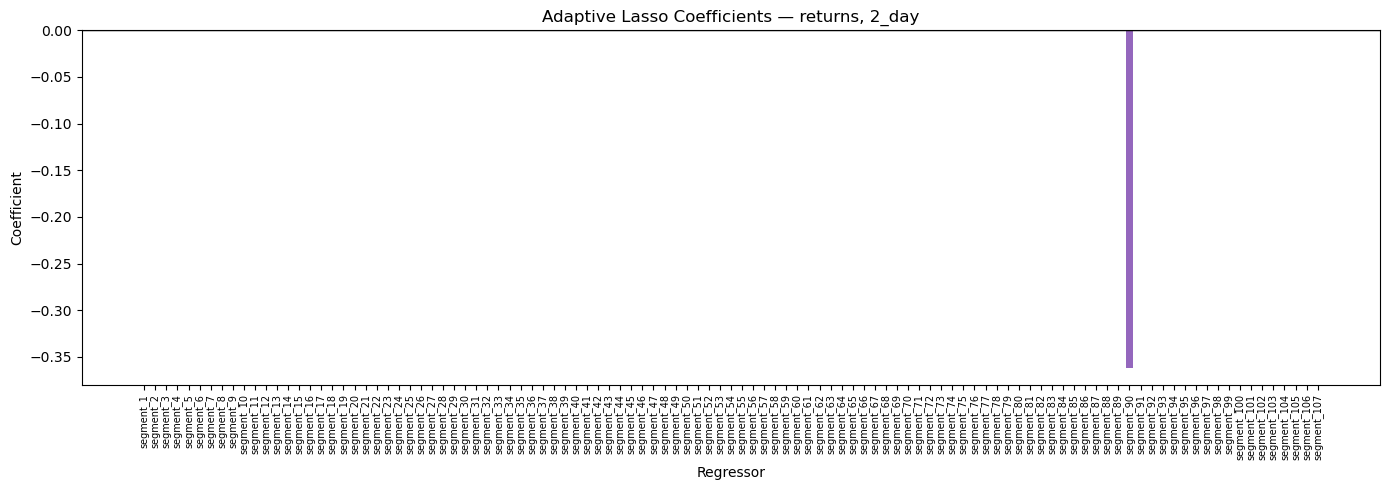

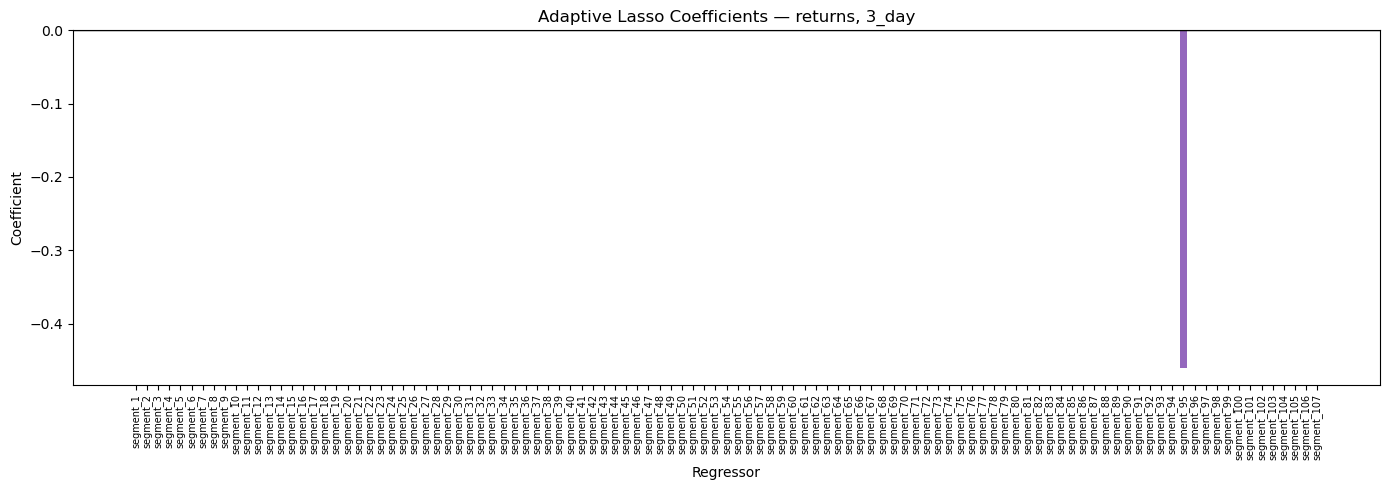

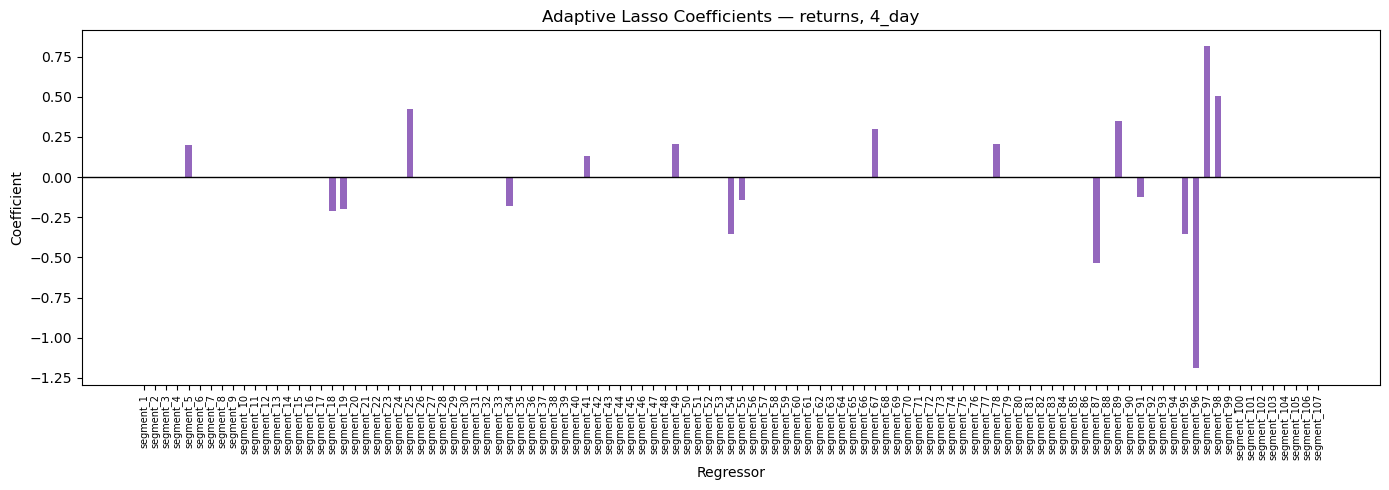

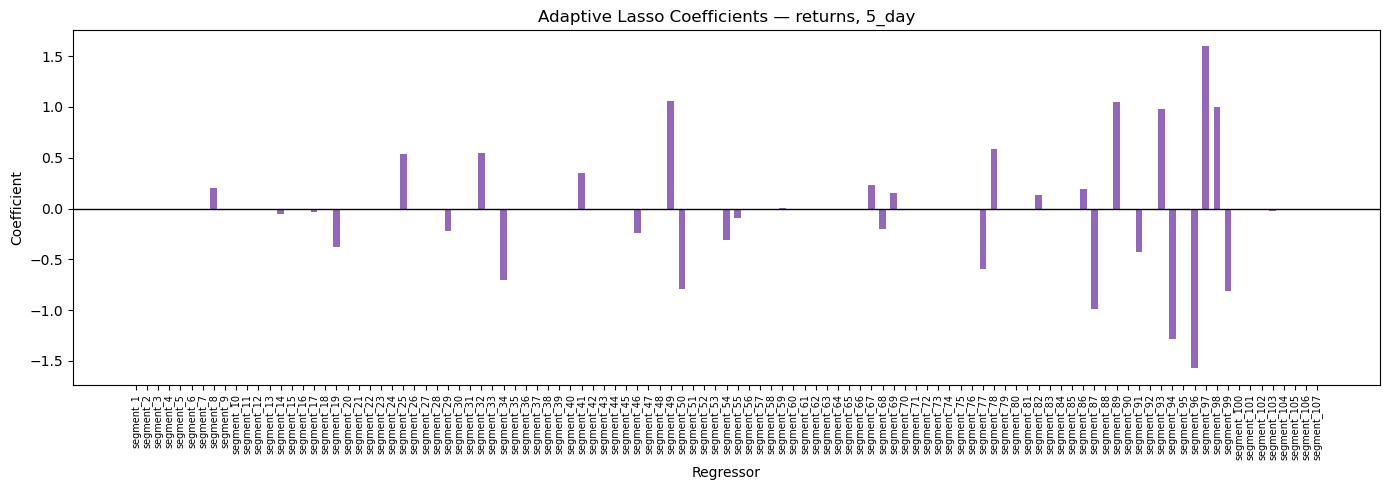

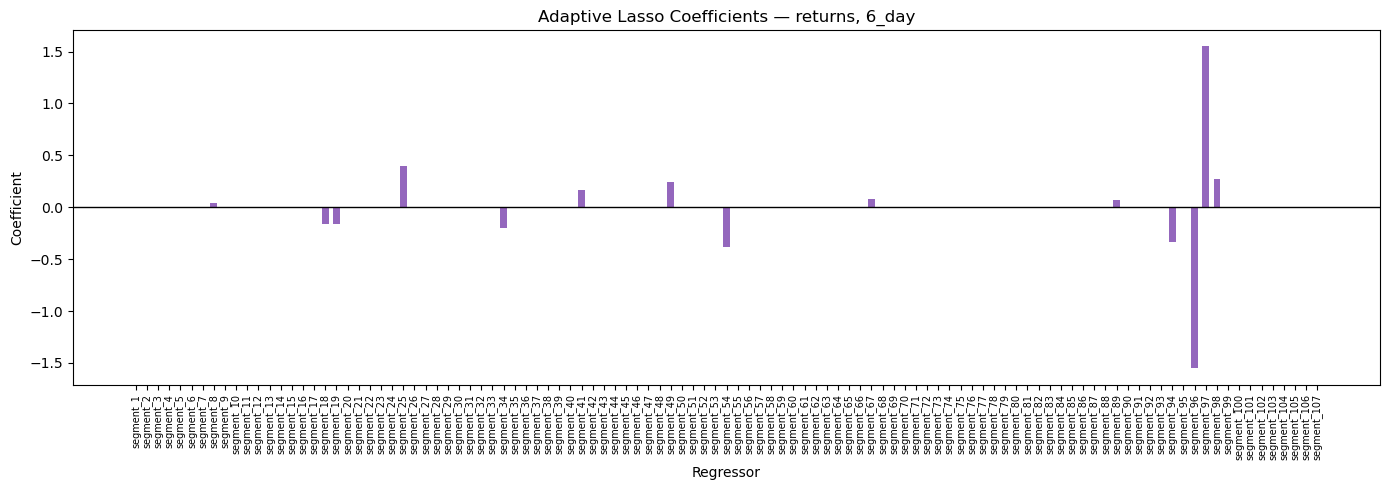

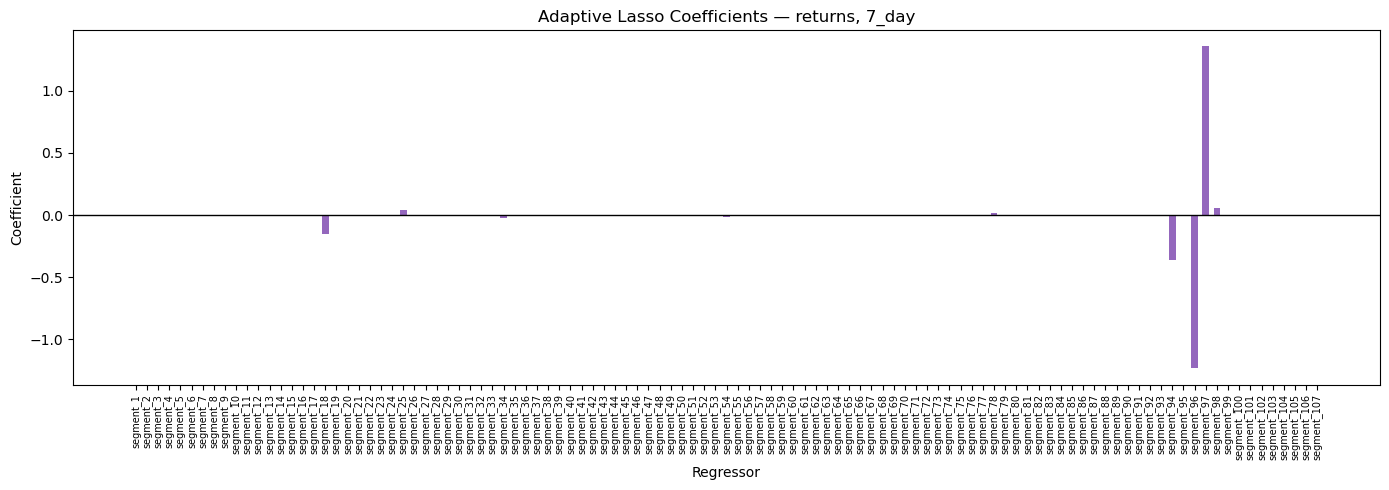

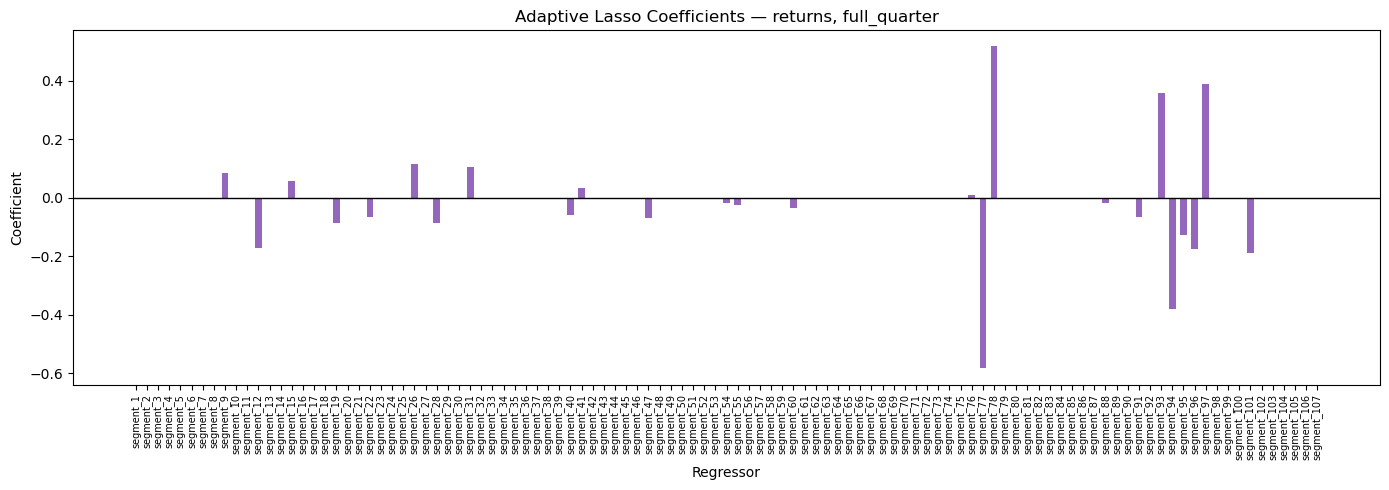

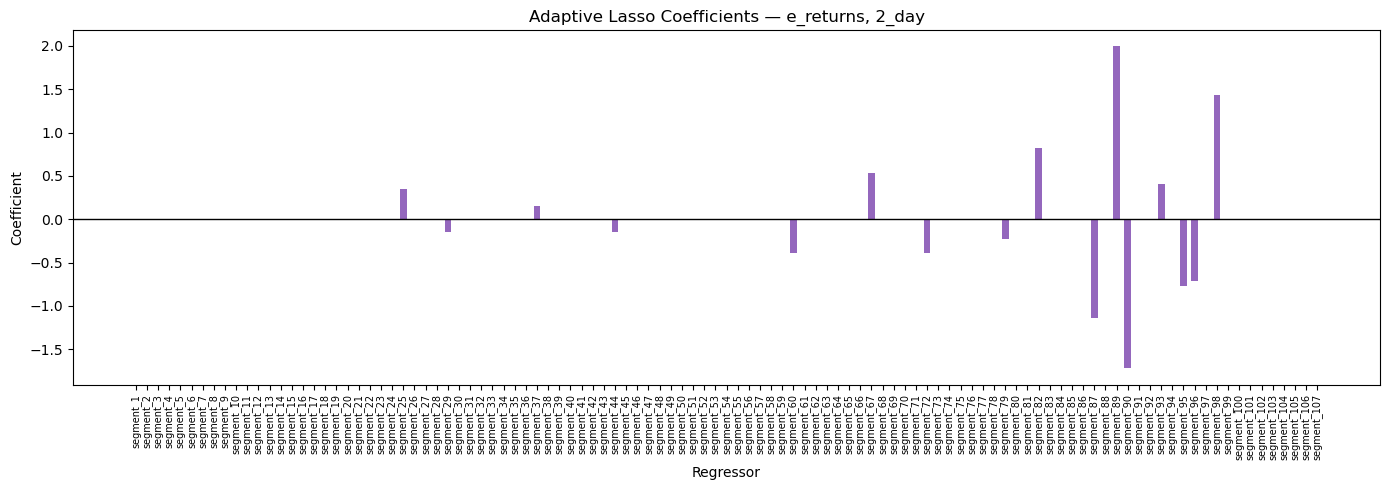

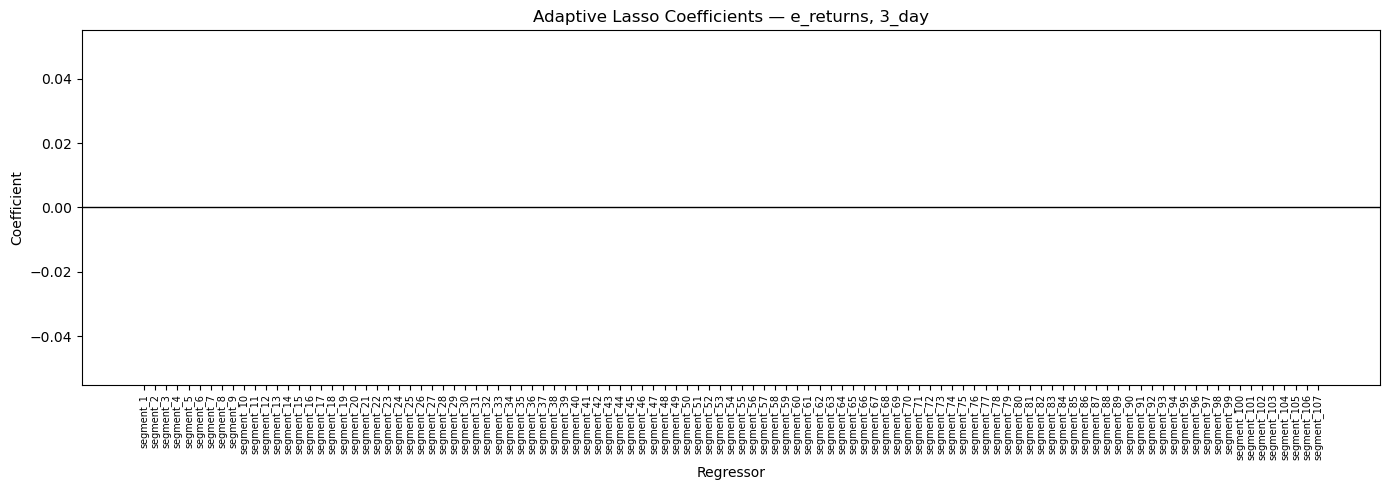

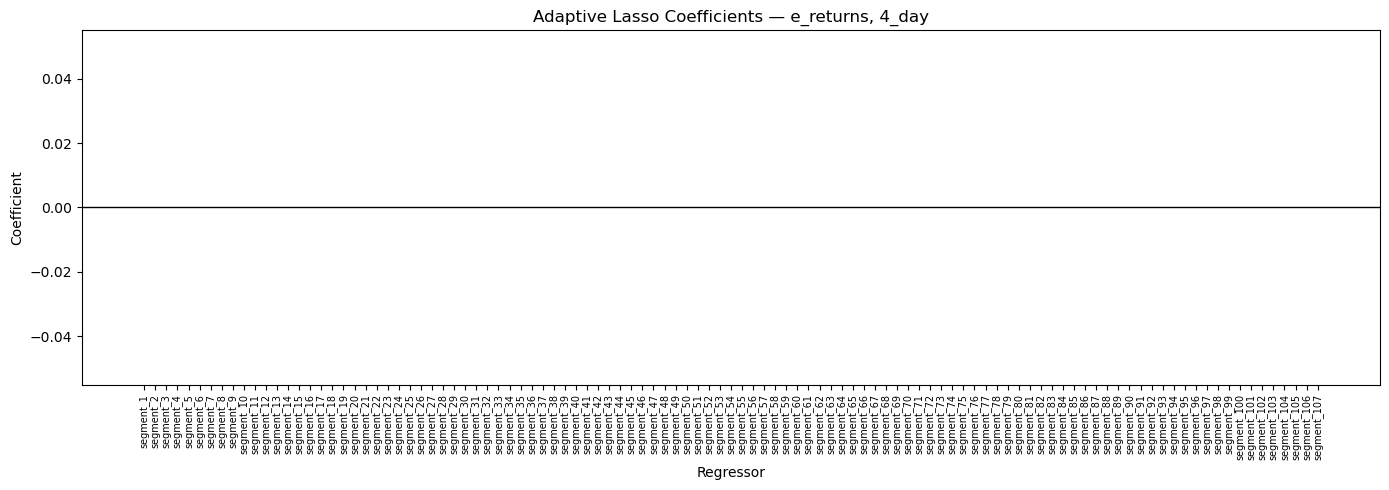

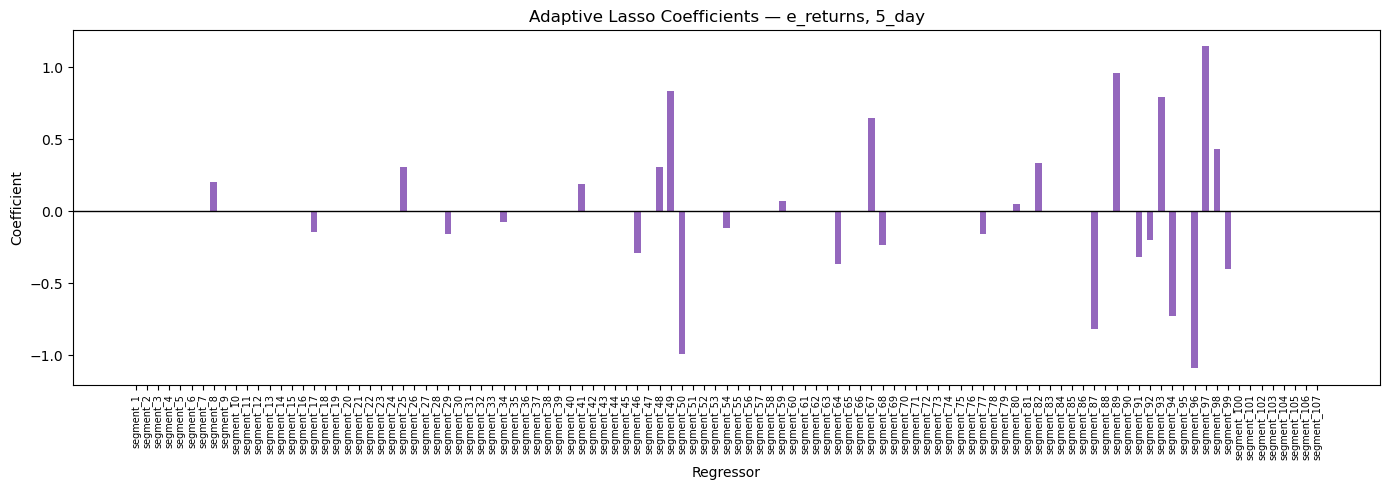

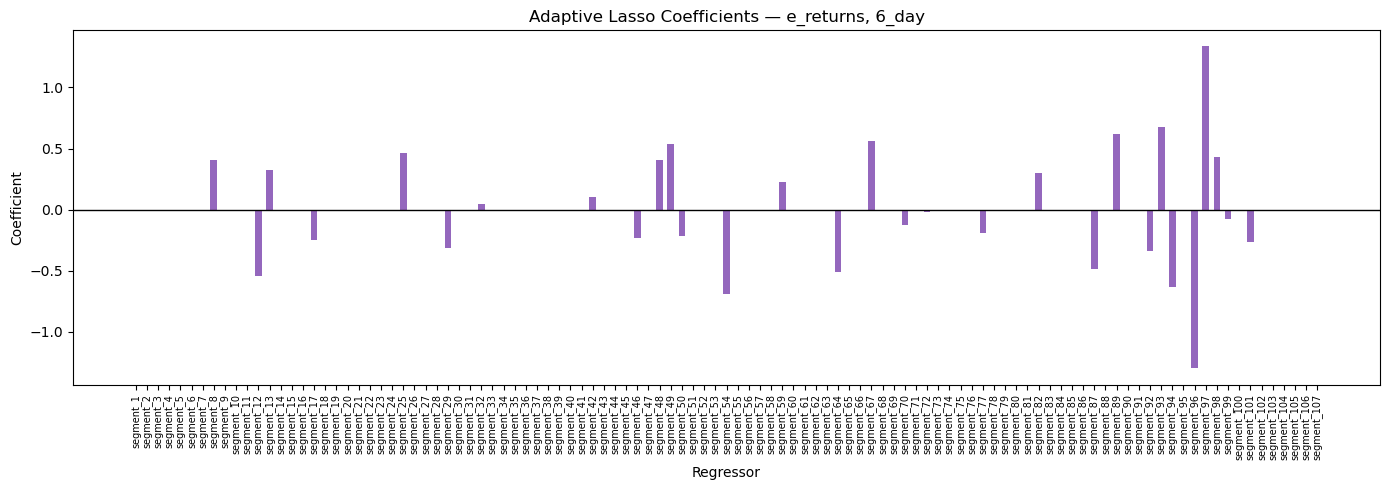

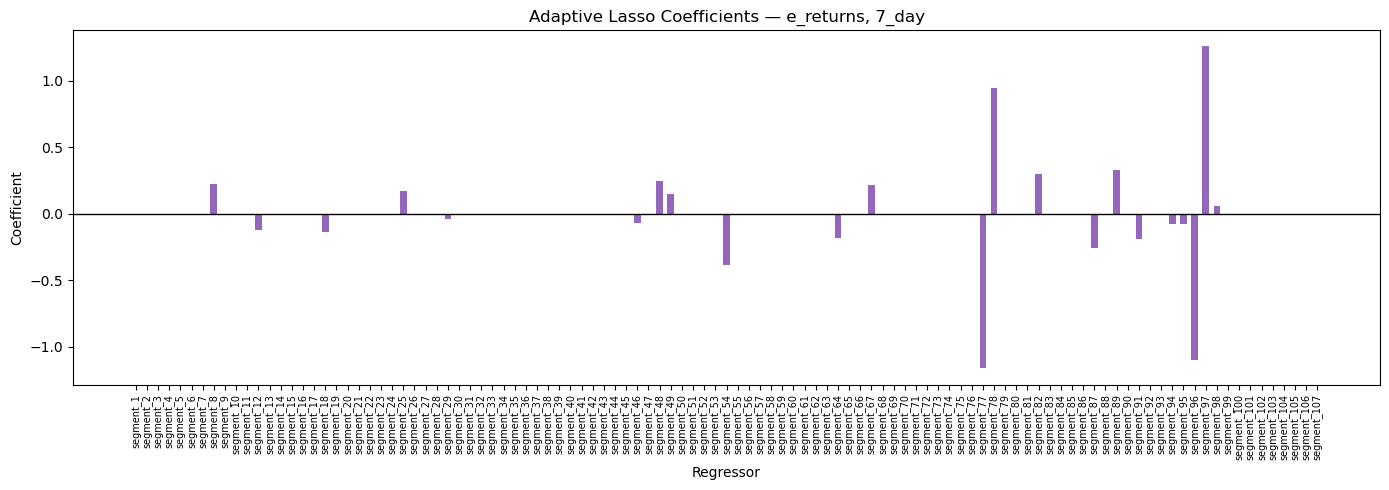

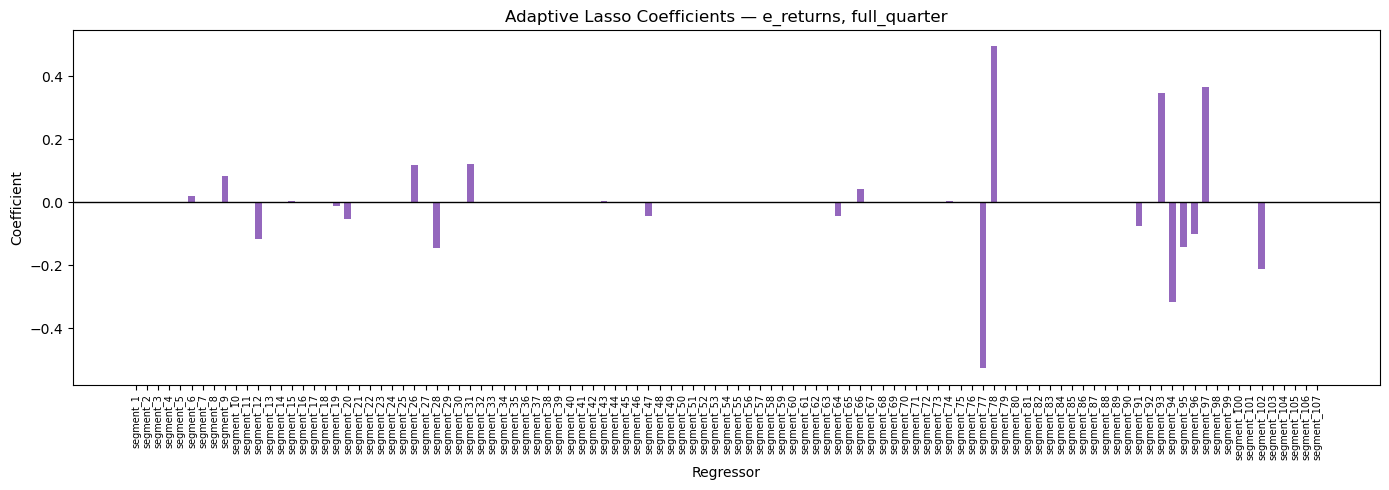

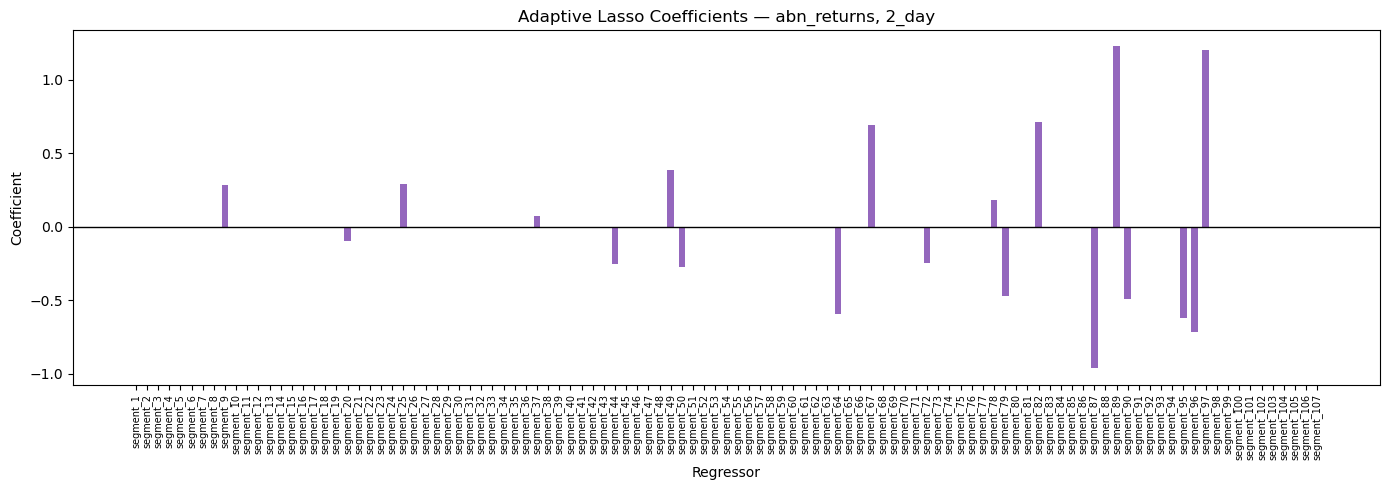

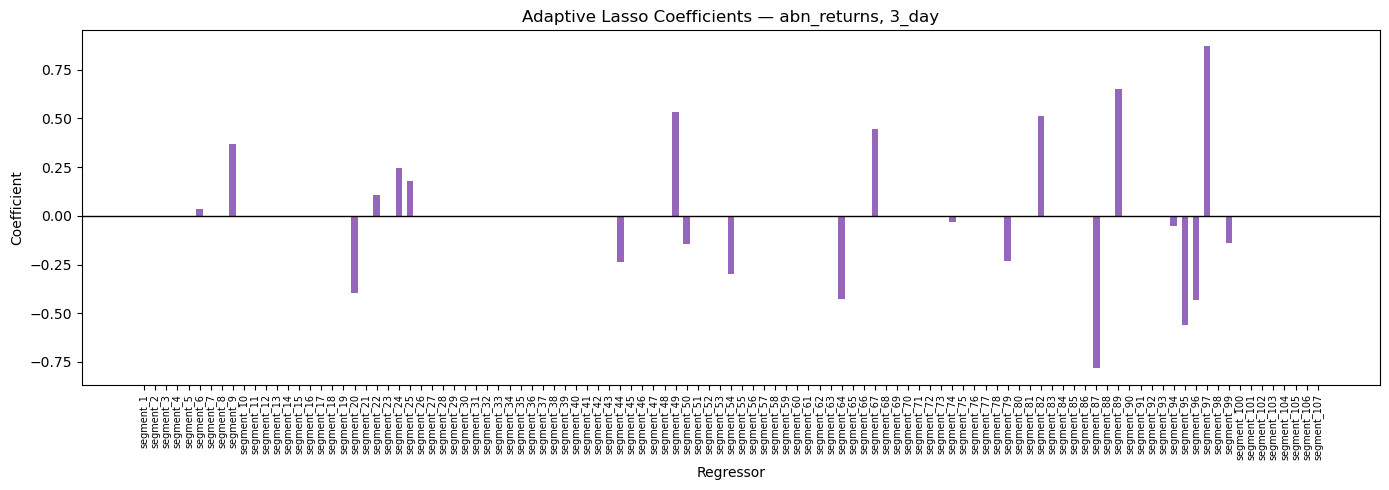

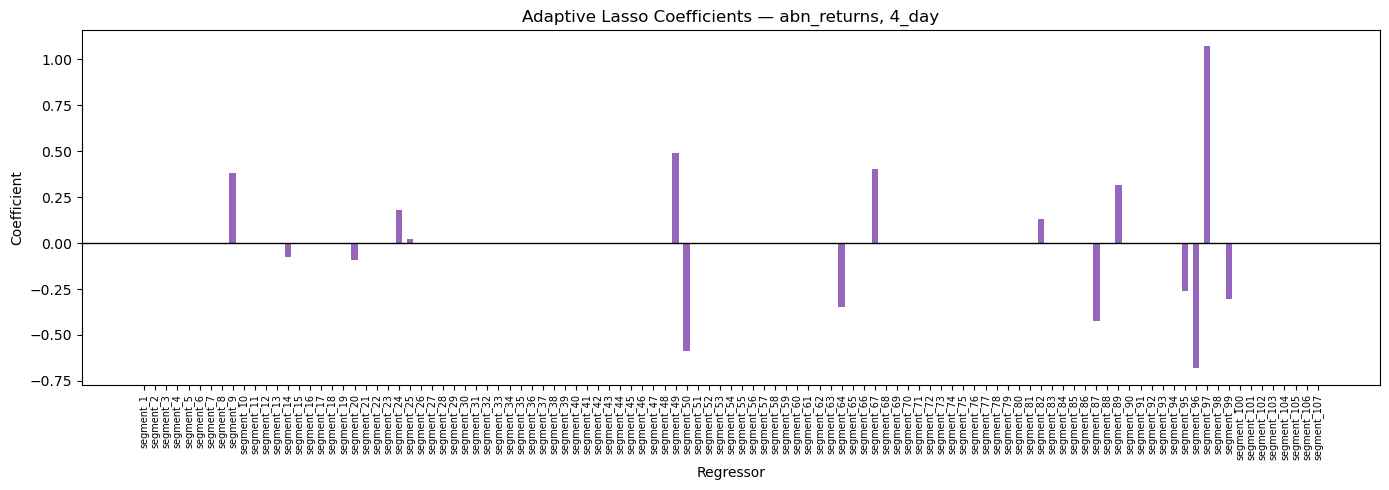

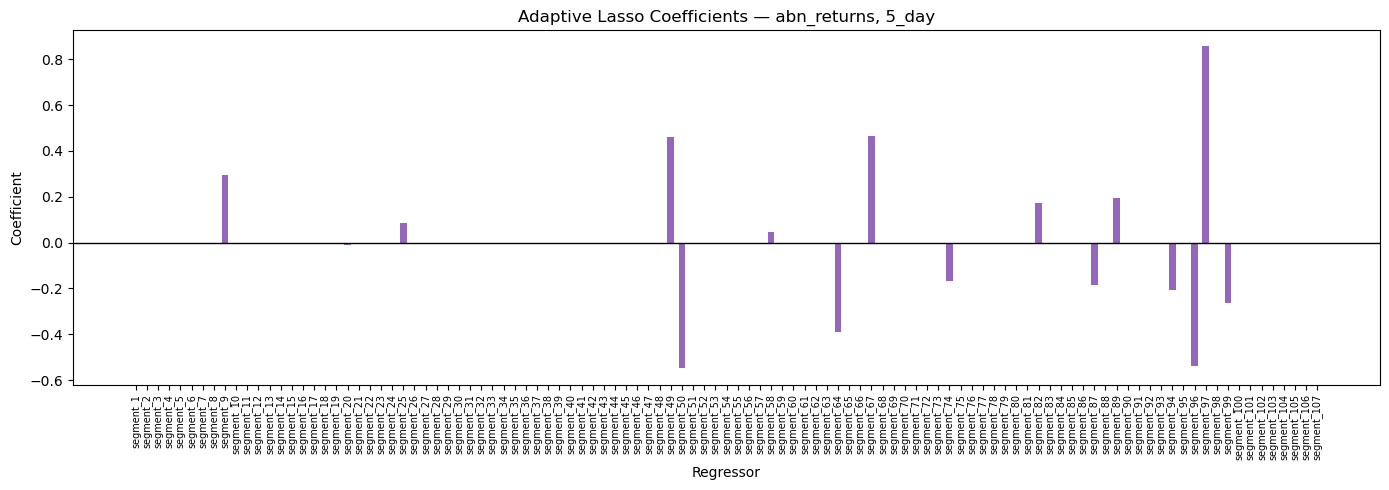

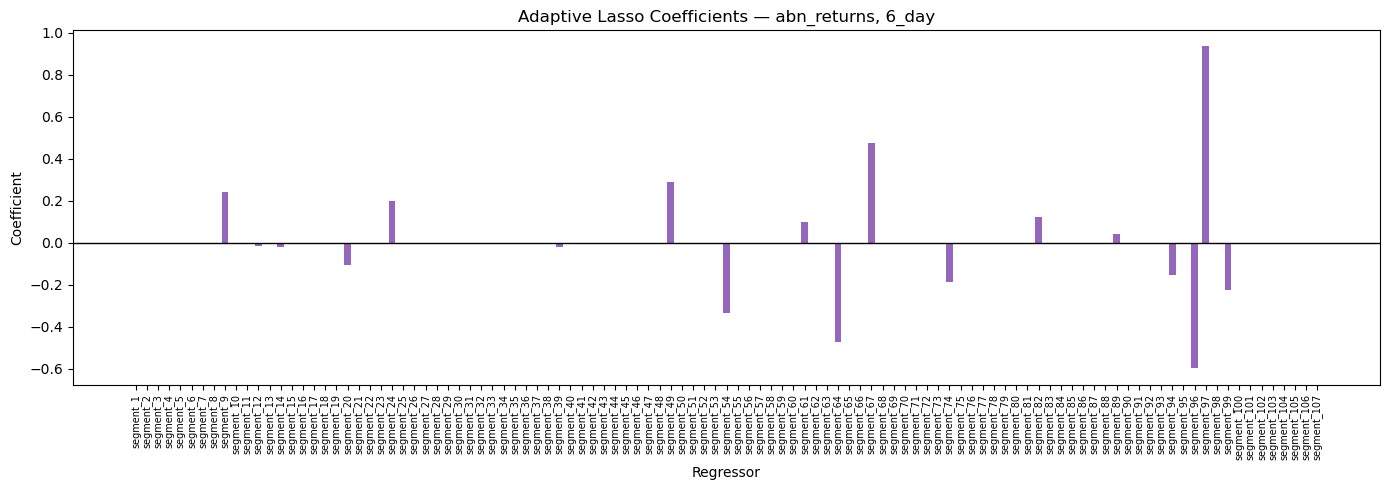

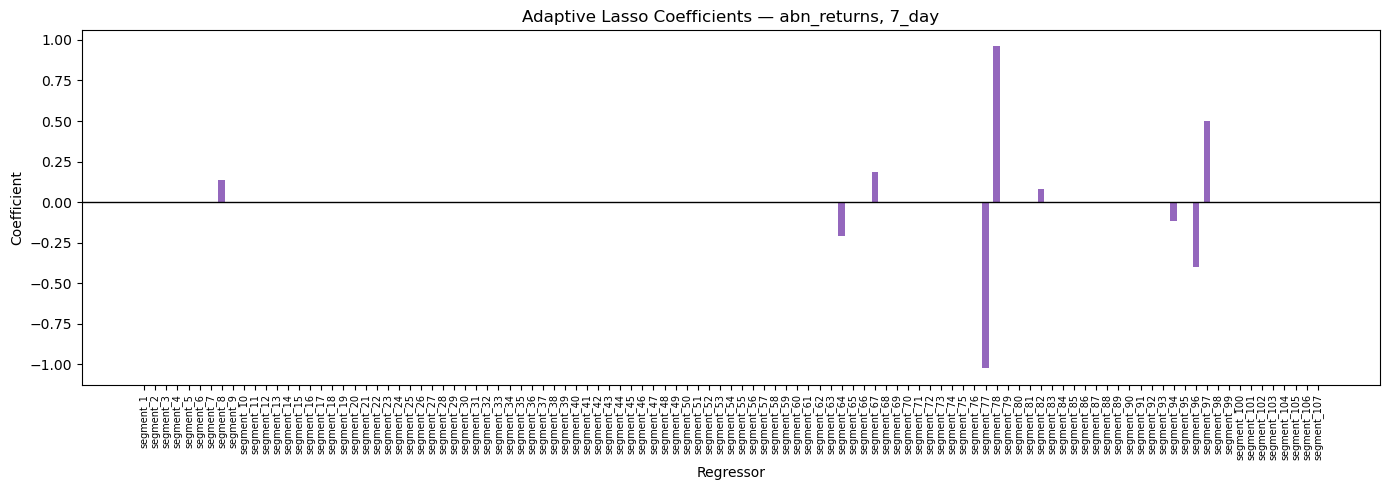

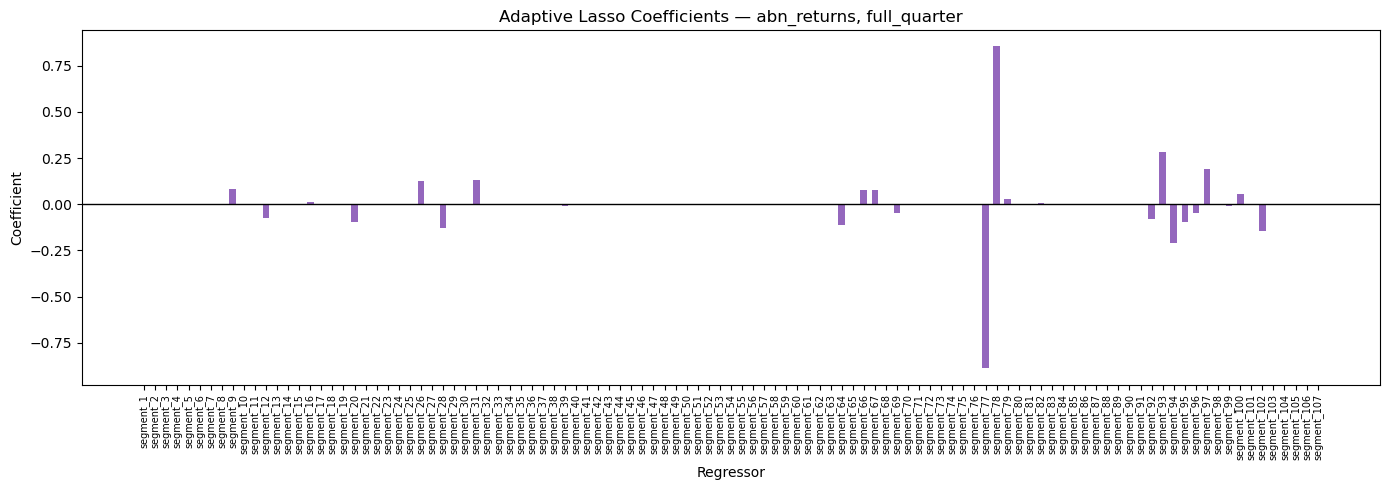

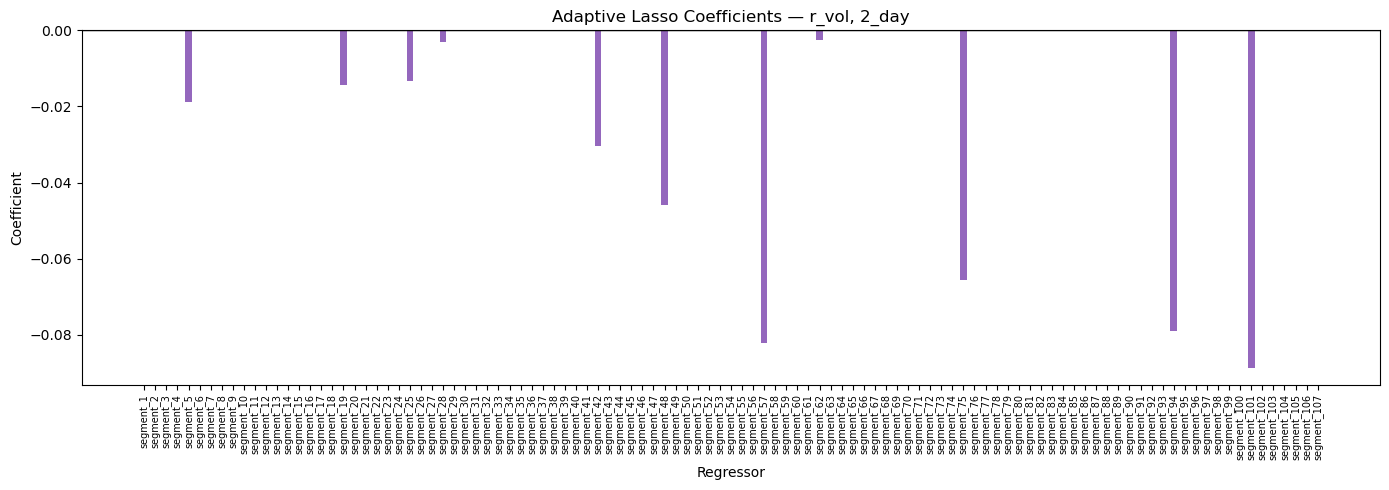

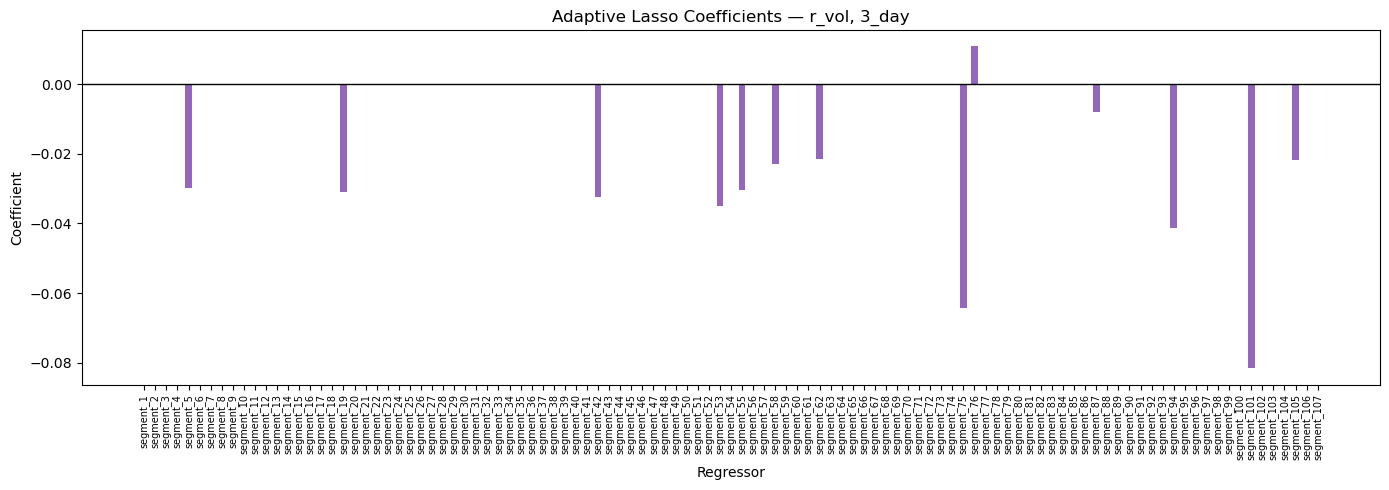

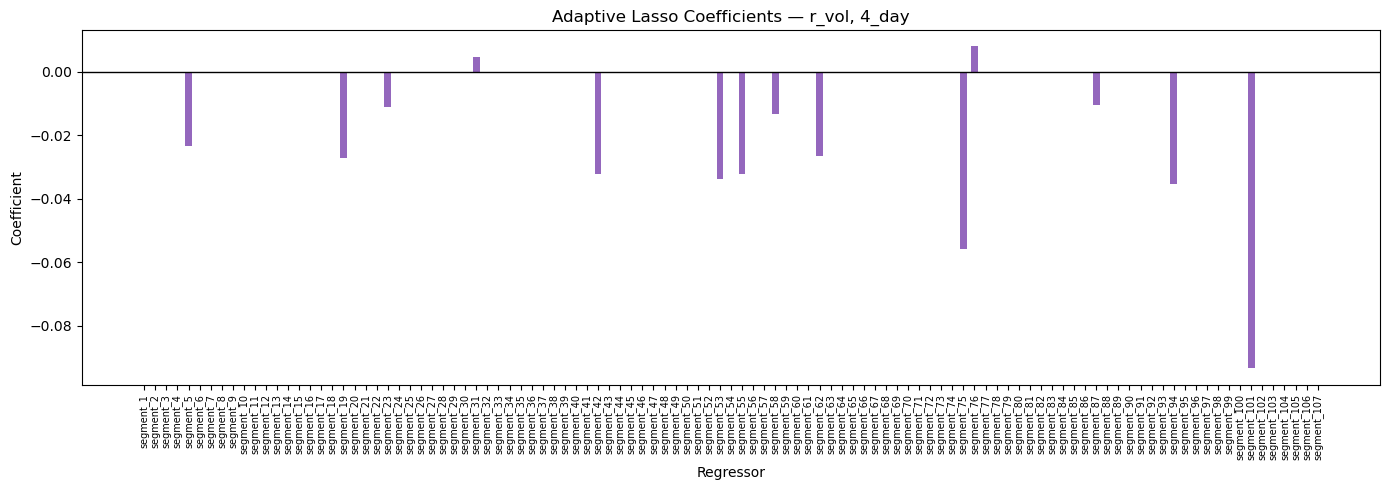

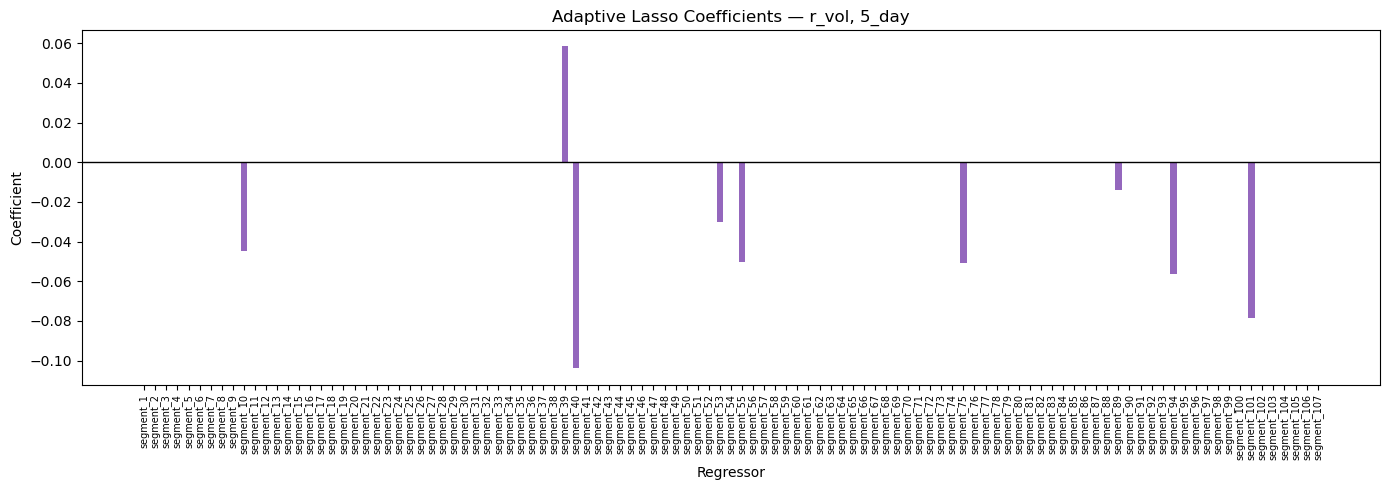

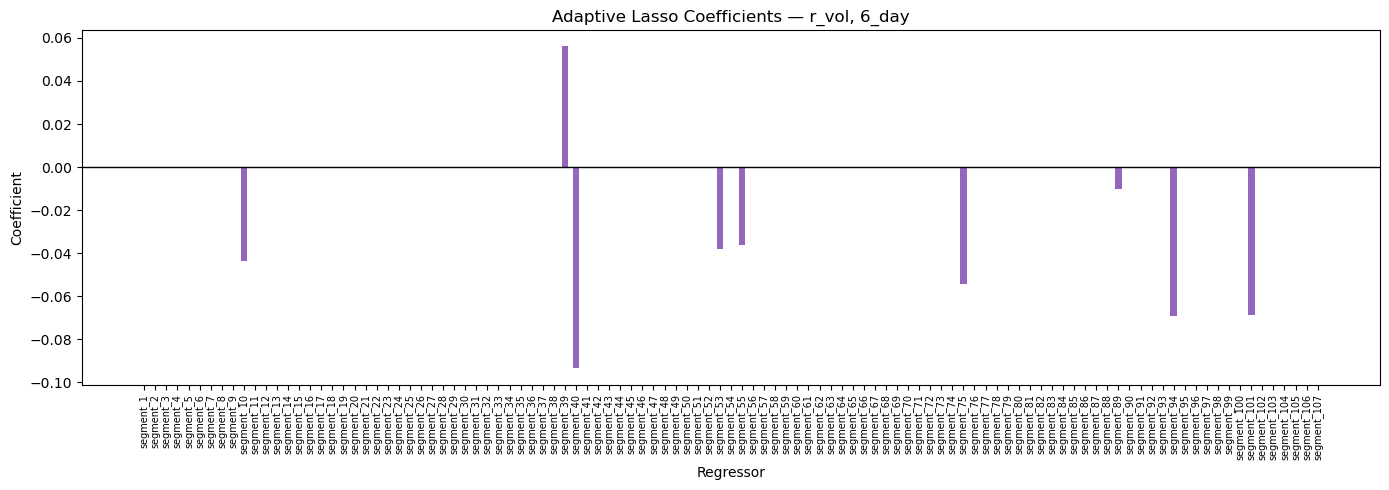

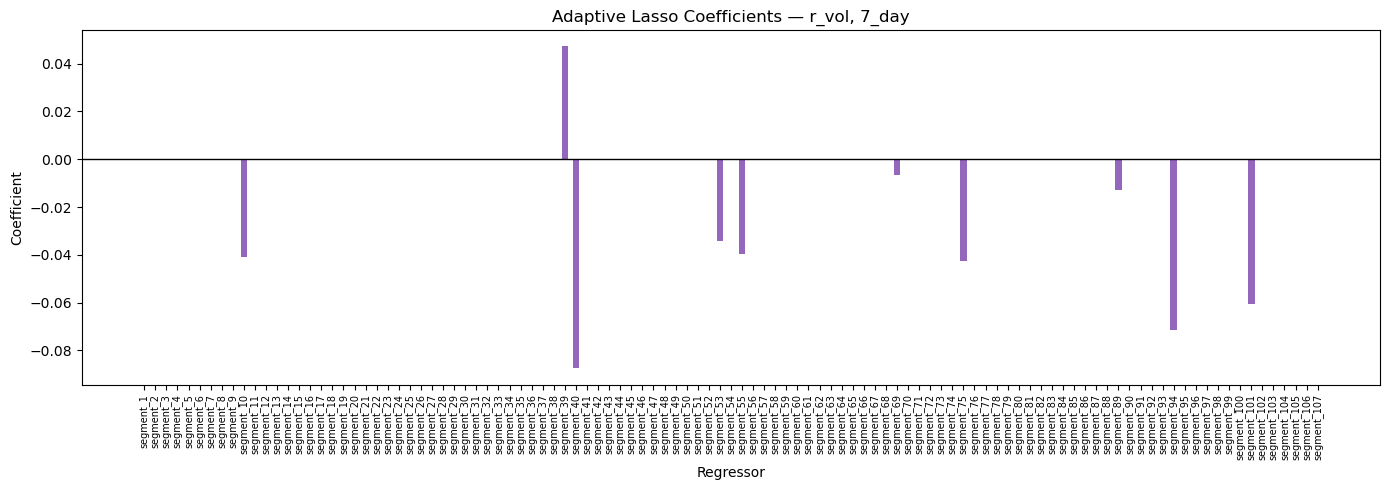

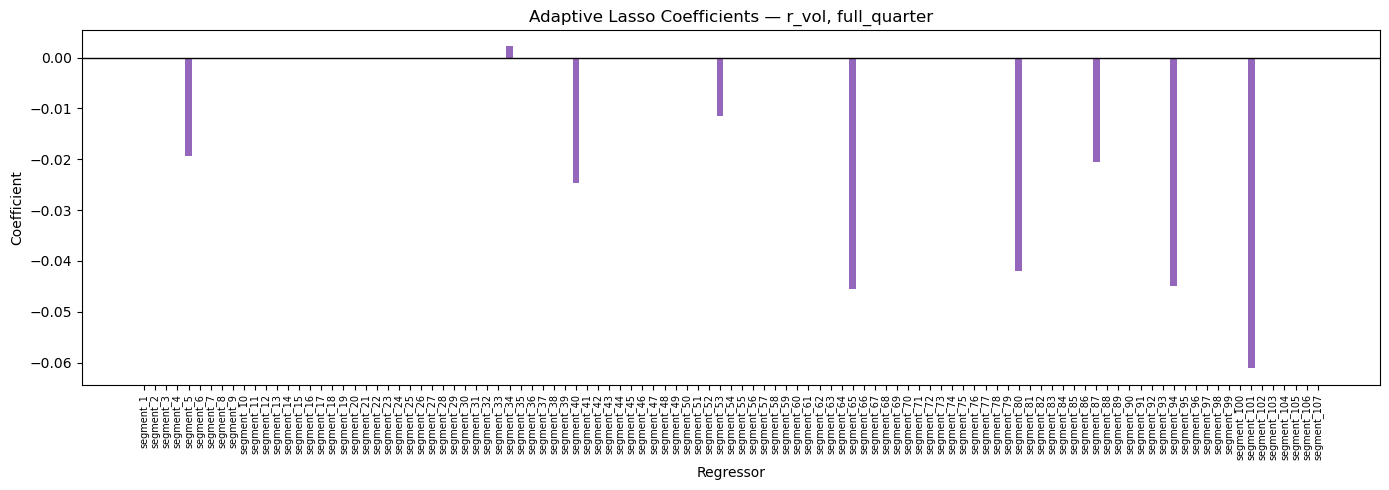

In [12]:
model.plot_adaptive_lasso(save=True)